#Cats vs. Dogs dataset




Getting the data as zipfile.

In [1]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2020-09-10 05:09:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.81.140.145, 2a02:26f0:fe00:1af::e59, 2a02:26f0:fe00:1b5::e59, ...
Connecting to download.microsoft.com (download.microsoft.com)|104.81.140.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   181MB/s    in 4.4s    

2020-09-10 05:09:24 (178 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



Unzipping and extracting the data to a folder

In [2]:
import os
import zipfile

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [8]:
print("Number of Cat Images: ",len(os.listdir('/tmp/PetImages/Cat')))
print("Number of Dog Images: ",len(os.listdir('/tmp/PetImages/Dog')))

Number of Cat Images:  12501
Number of Dog Images:  12501


Creating a directory structure of our own so that we can use the ImageDataGenerator to load the images and label them.

os.mkdir() to create directories

In [10]:
try:
  os.mkdir('/tmp/cats-v-dogs')
  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')
  os.mkdir('/tmp/cats-v-dogs/testing')
  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
  print("OS error")
  pass

Defining a function to take the data from the PetImages folder and place it in the new directories that we have created.

In [11]:
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  source_list = os.listdir(SOURCE)
  source_size = len(source_list)
  source_list = random.sample(source_list, source_size)

  split_index = int(source_size * SPLIT_SIZE)
  # +1 because slicing excludes the index itself
  training_list = source_list[0:split_index+1]
  testing_list = source_list[split_index+1:]

  for img in training_list:
        img_size=os.path.getsize(SOURCE+img)
        if(img_size != 0):
            copyfile(SOURCE+img,TRAINING+img)
  for img in testing_list:
        img_size=os.path.getsize(SOURCE+img)
        if(img_size != 0):
            copyfile(SOURCE+img,TESTING+img)

  


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [15]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


Now let us build a model with 3 convolution layers

In [16]:
import tensorflow as tf

In [18]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16,(3,3),activation="relu",input_shape=(150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512,activation="relu"),
                                    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [20]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

Now that we have our model lets get the training and validation generators

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./225)

train_generator = train_datagen.flow_from_directory('/tmp/cats-v-dogs/training',
                                                    target_size=(150,150),
                                                    batch_size=256, # 44
                                                    class_mode="binary")

validation_datagen = ImageDataGenerator(rescale=1./225)

validation_generator = validation_datagen.flow_from_directory('/tmp/cats-v-dogs/testing',
                                                    target_size=(150,150),
                                                    batch_size=32, # 40
                                                    class_mode="binary")


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [22]:
history = model.fit(train_generator,
          steps_per_epoch=44,
          epochs=10,
          validation_data=validation_generator,
          validation_steps=40)

Epoch 1/10
29/44 [==================>...........] - ETA: 1:10 - loss: 1.3800 - accuracy: 0.5334

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

44/44 [==============================] - 219s 5s/step - loss: 1.1382 - accuracy: 0.5510 - val_loss: 0.6833 - val_accuracy: 0.5188
Epoch 2/10
44/44 [==============================] - 216s 5s/step - loss: 0.6703 - accuracy: 0.6003 - val_loss: 0.6393 - val_accuracy: 0.6797
Epoch 3/10
44/44 [==============================] - 217s 5s/step - loss: 0.6603 - accuracy: 0.6380 - val_loss: 0.6230 - val_accuracy: 0.6711
Epoch 4/10
44/44 [==============================] - 217s 5s/step - loss: 0.6057 - accuracy: 0.6729 - val_loss: 0.5561 - val_accuracy: 0.7289
Epoch 5/10
44/44 [==============================] - 216s 5s/step - loss: 0.5712 - accuracy: 0.7033 - val_loss: 0.9350 - val_accuracy: 0.5805
Epoch 6/10
44/44 [==============================] - 216s 5s/step - loss: 0.5373 - accuracy: 0.7326 - val_loss: 0.5541 - val_accuracy: 0.7117
Epoch 7/10
44/44 [==============================] - 220s 5s/step - loss: 0.4956 - accuracy: 0.7534 - val_loss: 0.5134 - val_accuracy: 0.7406
Epoch 8/10
44/44 [======

Text(0.5, 1.0, 'Training and validation loss')

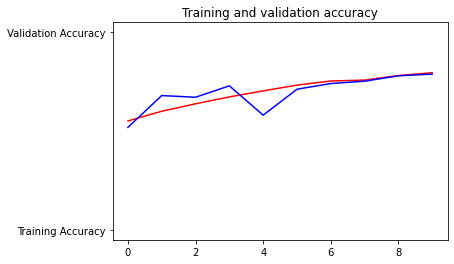

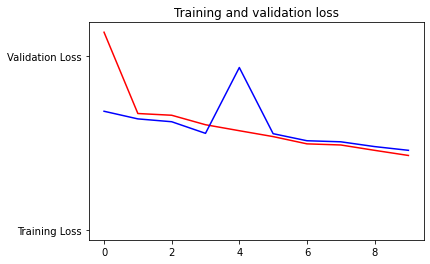

In [23]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

Testing by uploading our own images

In [26]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving images.jpg to images.jpg
[1.]
images.jpg is a dog


Conclusion: The model performs better than cat-v-dog-0 and it doesnot overfit. If we increase the convolution layers and the number of epochs. I think we can get a even better accuracy. Exploring the other options in the next notebook.